# API Key 설정

In [6]:
import dotenv
dotenv.load_dotenv()

True

# Build a Basic Chatbot

- `State` 클래스는 LangGraph에서 공유되는 상태(State)의 스키마(type 정의)를 담당한다.
- 즉, 각 노드(node)간 전달되는 데이터의 구조를 명시하는 역할을 한다.
- 아래의 경우 `state["messages"] = [Message1, Message2, ...]` 처럼 메세지를 담은 리스트를 상태로 유지하게 된다.
- `StateGraph`는 LangGraph 프레임워크의 핵심 객체 중 하나로, **상태 기반**으로 동작하는 LLM 에이전트 워크플로우를 만들기 위해 사용한다.
- `StateGraph`는 LangGraph에서 여러 노드(node) 상태(state)를 기반으로 연결해주는 그래프이다.
- LLM 에이전트들이 어떤 순서로 동작하고, 무엇을 공유할지 정의한다.

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages] #List 타입에 add_messages라는 상태 업데이트 전략을 붙임

graph_builder = StateGraph(State)

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
)

In [11]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 첫번째 인자는 unique node명
# 두번째 인자는 언제든 호출될 수 있는 함수 혹은 객체
graph_builder.add_node("chatbot", chatbot)

- 챗봇 노드 함수가 현재 상태(State)를 입력으로 받아들이고, "messages"라는 키 아래에 업데이트된 메세지 목록을 포함하는 딕셔너리를 반환

## 진입점 추가(Entry Point)
- 그래프가 매번 실행될 때 어디에서 작업을 시작할지 지정

In [12]:
graph_builder.add_edge(START, "chatbot")

## 종료 지점 추가(Finish Point)
- 그래프에게 "이 노드가 실행될 떄마다, 여기서 종료할 수 있다"는 지시 추가

In [13]:
graph_builder.add_edge("chatbot", END)

## Compile Graph

In [ ]:
# 실행 가능한 compiled graph 생성
graph = graph_builder.compile()

## graph 시각화

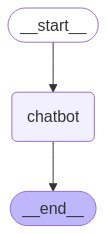

In [16]:
graph

## 챗봇 실행 테스트
- "quit", "exit", "q"를 입력하면 채팅 루프 종료 가능

In [20]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello Kim! How can I assist you today?
Assistant: I'm sorry, I do not know your name as I am an AI assistant and do not have access to personal information.
Goodbye!


# Part 2: Enhancing the Chatbot with Tools
- Part 1의 경우 `add_messages`를 통해 단순히 메세지 히스토리를 추가했다면,
- Part 2는 웹 검색 도구를 통합

In [21]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"Langraph: nodes, states, and edges. At the heart of LangGraph is the concept of a stateful graph:. State: Represents the context or memory that is maintained and updated as the computation ... LangGraph is a message-passing framework for building modular, graph-based systems. At its core, it focuses on communication between nodes via structured states and logical edges, enabling a ... In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ... LangGraph is a powerful tool that allows you to structure your JavaScript or TypeScript applications (including AI agent workflows) as a graph of interconnected computations. ... Nodes: node1 ... Nodes represent units of work within LangGraph. Each graph node is a

In [22]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
)

# 도구 사용이 가능하다는 정보만 제공
# tool 호출 여부는 LLM이 결정
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## BasicToolNode

In [24]:
import json
from typing import List
from langchain_core.messages import ToolMessage

# BasicToolNode는 AIMessage에 포함된 tool_calls 정보를 읽고,
# 실제 해당 tool을 실행한 뒤 -> ToolMessage로 만들어 반환하는 역할
class BasicToolNode:
    """A node that runs the tools requested in tha last AIMessage."""

    # tool 리스트를 받아서 `이름: 툴객체` 형태의 딕셔너리로 정리
    # 나중에 AI가 호출한 tool 이름을 기준으로 실행할 수 있게 준비
    def __init__(self, tools: List) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    # LangGraph 노드 형태로 사용됨 (__call__ = 노드 실행 진입점)
    # 가장 마지막 메세지에서 tool_calls 추출   
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            messages = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []

        # 실제 tool을 호출 실행하는 부분
        for tool_call in messages.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # 결과를 ToolMessage 형태로 반환
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## Tool Condition 설정

- LangGraph에서 Tool 사용을 조건적으로 분기 처리하는 완성된 그래프 구성
- LLM이 tool을 호출했는지 아닌지에 따라 흐름을 다르게 제어

"""[START]
   ↓
[chatbot] --(tool_call 존재)--> [tools] --→ [chatbot] (재진입)
   └──────(없음)────────────→ [END]"""

In [26]:
from typing import Literal

# LLM의 마지막 응답 메세지를 보고, tool_call이 있으면 -> tools
# 없으면 __end__ 로 흐름 제어
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    # 가장 마지막 메세지에 tool_calls 속성을 가지고 있고, 1개 이상이면 "tools"로 라우팅
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools, # route_tools의 리턴 값에 따라 다음 노드 분기
    {"tools": "tools", "__end__": "__end__"},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

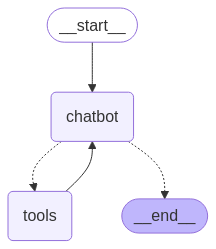

In [27]:
graph

In [30]:
# 테스트 프롬프트 : what's langgraph all about?

from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: "\uc724\uc11d\uc5f4 \ub300\ud1b5\ub839 \ud0c4\ud575\uc18c\ucd94\uc548\uc5d0 \ub300\ud55c \ud5cc\ubc95\uc7ac\ud310\uc18c\uc758 \uc120\uace0 \uc694\uc9c0\uc640 \uacb0\uc815\ubb38\uc744 \ubcf4\uae30 \uc27d\uac8c \uc815\ub9ac\ud588\uc2b5\ub2c8\ub2e4. \ud0c4\ud575 \uc18c\ucd94\uc758 \uc801\ubc95 \uc5ec\ubd80\uc640 \ud5cc\ubc95 \ubc0f \ubc95\ub960 \uc704\ubc30 \ud589\uc704\uc5d0 \ub300\ud55c \ud310\ub2e8, \ub9c8\uc9c0\ub9c9\uc73c\ub85c \ud0c4\ud575 \ud0c0\ub2f9\uc131\uae4c\uc9c0 \uc8fc\uc694 \ud56d\ubaa9\ubcc4\ub85c \ud55c\ub208\uc5d0 \ud750\ub984\uc744 \uc774\ud574\ud558\uc2e4 \uc218 \uc788\ub3c4\ub85d \uad6c\uc131\ud588\uc2b5\ub2c8\ub2e4. \ud5cc\ubc95\uc7ac\ud310\uc18c\uac00 \uad6d\ud68c\uc758 \ud0c4\ud575\uc18c\ucd94 \uccad\uad6c\ub97c \uc778\uc6a9\ud558\uba74 \uc724 \ub300\ud1b5\ub839\uc740 \ubc15\uadfc\ud61c \uc804 \ub300\ud1b5\ub839\uc5d0 \uc774\uc5b4 \uc784\uae30 \uc911 \ud30c\uba74\ub418\ub294 \ub450 \ubc88\uc9f8 \ub300\ud1b5\ub839\uc73c\ub85c \uae30\ub85d\ub41